<a href="https://colab.research.google.com/github/SahelKherad/3-story-benchmark-transformer/blob/main/boom_40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import scipy.io
from scipy.io.matlab._mio5_params import mat_struct
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/ASCE"


shm01a.mat  shm03a.mat	shm05a.mat  shm07a.mat	shm09a.mat
shm02a.mat  shm04a.mat	shm06a.mat  shm08a.mat


In [ ]:
import scipy.io

folder_path = '/content/drive/MyDrive/ASCE/shm01a.mat'
data = scipy.io.loadmat(folder_path)

print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'dasy', 'dasy_dscr', 'filedescription', 'fsdasy'])


In [ ]:
print('header:', data['__header__'])
print('version:',data['__version__'])
print('File description: ', data['filedescription'])
print('description:',data['dasy_dscr'])
# print(data['dasy'])

header: b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Sun Sep 29 12:53:06 2002'
version: 1.0
File description:  ['Type:a (Ambient Vibration/Filtered Data) --  Config01: Fully Braced Config     ']
description: [[(array(['Base West side - EPI sensor X direction (N+)'], dtype='<U44'), array(['Base Center - EPI sensor Y direction (W+)'], dtype='<U41'), array(['Base East side - EPI sensor X direction (N+)'], dtype='<U44'), array(['1st Floor - N/S EPI Sensor at West end (N+)'], dtype='<U43'), array(['1st Floor - E/W FBA Sensor at Center (W+)'], dtype='<U41'), array(['1st Floor - N/S FBA Sensor at East end (N+)'], dtype='<U43'), array(['2nd Floor - N/S FBA Sensor at West end (N+)'], dtype='<U43'), array(['2nd Floor - E/W EPI Sensor at Center (W+)'], dtype='<U41'), array(['2nd Floor - N/S EPI Sensor at East end (N+)'], dtype='<U43'), array(['3rd Floor - N/S EPI Sensor at West end (N+)'], dtype='<U43'), array(['3rd Floor - E/W EPI Sensor at Center (W+)'], dtype='<U41'), array(['3rd Floor 

In [ ]:
def load_mat(path):
    mat = scipy.io.loadmat(path, squeeze_me=True, struct_as_record=False)
    raw = mat.get('dasy')
    if isinstance(raw, mat_struct):
        fields = raw._fieldnames
        channels = []
        for f in fields:
            arr = getattr(raw, f)
            channels.append(np.asarray(arr).reshape(-1))
        data = np.stack(channels, axis=1)     # → (n_samples, n_channels)

    return data, mat


base_dir = '/content/drive/MyDrive/ASCE/'

# state_files is a dictionary:{ label_1: "file1.mat", label_2: "file2.mat", ... }
# label is an integer or class ID (e.g., 0, 1, 2). fname is the name of a .mat file.
state_files = {
    1: 'shm01a.mat',   # state 1 → label 0
    2: 'shm02a.mat',   # state 2 → label 1
    3: 'shm03a.mat',   # state 3 → label 2
    4: 'shm04a.mat',   # state 4 → label 3
    5: 'shm05a.mat',   # state 5 → label 4
    6: 'shm06a.mat',   # state 6 → label 5
    7: 'shm07a.mat',   # state 7 → label 6
    8: 'shm08a.mat',   # state 8 → label 7
    9: 'shm09a.mat',   # state 9 → label 8
}
print(state_files)

{1: 'shm01a.mat', 2: 'shm02a.mat', 3: 'shm03a.mat', 4: 'shm04a.mat', 5: 'shm05a.mat', 6: 'shm06a.mat', 7: 'shm07a.mat', 8: 'shm08a.mat', 9: 'shm09a.mat'}


In [ ]:
all_data, all_labels = [], []
for label, fname in state_files.items():
    path = os.path.join(base_dir, fname)
    dasy, mat = load_mat(path)
    print(f"{fname}: data shape = {dasy.shape}")
    all_data.append(dasy)
    all_labels.append(np.full(dasy.shape[0], label, dtype=np.int64))
print('Len Data == ',len(all_data))
all_data_concatenated = np.concatenate(all_data, axis=0)
all_label_concatenated = np.concatenate(all_labels)

print('all_data_concatenated: ', all_data_concatenated.shape)
print('all_label_concatenated: ', all_label_concatenated.shape)

# for i, arr in enumerate(all_data):
#     print(f"  Array {i+1}: {arr.shape}")



shm01a.mat: data shape = (60000, 16)
shm02a.mat: data shape = (60000, 16)
shm03a.mat: data shape = (60000, 16)
shm04a.mat: data shape = (60000, 16)
shm05a.mat: data shape = (60000, 16)
shm06a.mat: data shape = (45568, 16)
shm07a.mat: data shape = (180000, 16)
shm08a.mat: data shape = (180000, 16)
shm09a.mat: data shape = (180000, 16)
Len Data ==  9
all_data_concatenated:  (885568, 16)
all_label_concatenated:  (885568,)


In [ ]:
data_state1 = all_data[0]
data_state2 = all_data[1]
data_state3 = all_data[2]
data_state4 = all_data[3]
data_state5 = all_data[4]
data_state6 = all_data[5]
data_state7 = all_data[6]
data_state8 = all_data[7]
data_state9 = all_data[8]
# print(data_state1.dtype)
print(data_state1.shape)
print(data_state6.shape)
print(data_state8.shape)
# print(data_state2)

# all_data0 = np.vstack([data_state1, data_state2,data_state3, data_state4, data_state5, data_state6, data_state7, data_state8, data_state9])
# means   = all_data0.mean(axis=0, keepdims=True)    # shape (1,15)
# stds    = all_data0.std (axis=0, keepdims=True)

# data_state1 = (data_state1 - means) / stds
# data_state2 = (data_state2 - means) / stds
# data_state3 = (data_state3 - means) / stds
# data_state4 = (data_state4 - means) / stds
# data_state5 = (data_state5 - means) / stds
# data_state6 = (data_state6 - means) / stds
# data_state7 = (data_state7 - means) / stds
# data_state8 = (data_state8 - means) / stds
# data_state9 = (data_state9 - means) / stds


(60000, 16)
(45568, 16)
(180000, 16)


In [ ]:
def segment_signal(x, L=1024, S=512):
    n_samples, n_channels = x.shape
    n_windows = int(np.floor((n_samples - L) / S) + 1)
    windows = []

    for start in range(0, n_samples - L + 1, S):
        windows.append(x[start:start+L, 0:15])
    return np.stack(windows, axis=0)

seg1 = segment_signal(data_state1, L=1024, S=512) # return(n_windows, L, n_channels)
seg2 = segment_signal(data_state2, L=1024, S=512)
seg3 = segment_signal(data_state3, L=1024, S=512)
seg4 = segment_signal(data_state4, L=1024, S=512)
seg5 = segment_signal(data_state5, L=1024, S=512)
seg6 = segment_signal(data_state6, L=1024, S=512)
seg7 = segment_signal(data_state7, L=1024, S=512)
seg8 = segment_signal(data_state8, L=1024, S=512)
seg9 = segment_signal(data_state9, L=1024, S=512)

print("State1 windows:", seg1.shape)
print("State2 windows:", seg2.shape)
print("State3 windows:", seg3.shape)
print("State4 windows:", seg4.shape)
print("State5 windows:", seg5.shape)
print("State6 windows:", seg6.shape)
print("State7 windows:", seg7.shape)
print("State8 windows:", seg8.shape)
print("State9 windows:", seg9.shape)

State1 windows: (116, 1024, 15)
State2 windows: (116, 1024, 15)
State3 windows: (116, 1024, 15)
State4 windows: (116, 1024, 15)
State5 windows: (116, 1024, 15)
State6 windows: (88, 1024, 15)
State7 windows: (350, 1024, 15)
State8 windows: (350, 1024, 15)
State9 windows: (350, 1024, 15)


In [ ]:
116*5+88+350*3


1718

In [ ]:
# X = np.vstack([seg1, seg3])
# y = np.concatenate([
#     np.zeros(len(seg1), dtype=np.int64),   # label 0 for state1
#     np.ones(len(seg3),  dtype=np.int64),   # label 1 for state3
# ])

X = np.vstack([seg1, seg2, seg3, seg4, seg5, seg6, seg7, seg8, seg9])
y = np.concatenate([
    np.zeros(len(seg1), dtype=np.int64),     # label 0 for state1
    1*np.ones(len(seg2),  dtype=np.int64),   # label 1 for state2
    2*np.ones(len(seg3),  dtype=np.int64),   # label 2 for state3
    3*np.ones(len(seg4),  dtype=np.int64),   # label 3 for state4
    4*np.ones(len(seg5),  dtype=np.int64),   # label 4 for state5
    5*np.ones(len(seg6),  dtype=np.int64),   # label 5 for state6
    6*np.ones(len(seg7),  dtype=np.int64),   # label 6 for state7
    7*np.ones(len(seg8),  dtype=np.int64),   # label 7 for state8
    8*np.ones(len(seg9),  dtype=np.int64),   # label 8 for state9

])
print("X shape:", X.shape) # (1718, 124, 15)
print("y shape:", y.shape, "unique labels:", np.unique(y)) # (1718,)


X shape: (1718, 1024, 15)
y shape: (1718,) unique labels: [0 1 2 3 4 5 6 7 8]


In [ ]:
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader

# --- your raw data arrays ---
# X: numpy array shape (1718, 124, 15)
# y: numpy array shape (1718,)
# --------------------------------

# 1) to‐tensor
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).long()

# 2) one big dataset
dataset = TensorDataset(X_tensor, y_tensor)

# 3) split sizes
N       = len(dataset)
n_train = int(0.8 * N)
n_val   = int(0.1 * N)
n_test  = N - n_train - n_val

# 4) initial split (just to get train indices)
train_ds, val_ds, test_ds = random_split(
    dataset,
    [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)
)

# 5) compute mean/std **only** on the TRAINING samples
train_indices = train_ds.indices   # these are the integer indices of train examples
X_train      = X_tensor[train_indices]  # shape (n_train, 124, 15)

# compute per-feature mean and std over both sample & time dims
mean = X_train.mean(dim=(0,1), keepdim=True)   # shape (1, 1, 15)
std  = X_train.std(dim=(0,1), keepdim=True)    # shape (1, 1, 15)

# 6) apply normalization to the *entire* dataset
X_tensor = (X_tensor - mean) / std

# 7) rebuild the normalized dataset and re-split using the *same* seed
dataset = TensorDataset(X_tensor, y_tensor)
train_ds, val_ds, test_ds = random_split(
    dataset,
    [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)
)

# 8) finally, DataLoaders
batch_size   = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# sanity check
xb, yb = next(iter(train_loader))
print("train batch X:", xb.shape)  # e.g. (64, 124, 15)
print("train batch y:", yb.shape)  # (64,)
print("normalized feature mean ~ 0:", xb.mean().item())
print("normalized feature std  ~ 1:", xb.std().item())


train batch X: torch.Size([64, 1024, 15])
train batch y: torch.Size([64])
normalized feature mean ~ 0: -0.0045063006691634655
normalized feature std  ~ 1: 1.0079970359802246


In [ ]:
# from torch.utils.data import random_split
# from torch.utils.data import TensorDataset
# from torch.utils.data import DataLoader

# # 1) Wrap in a Dataset
# # class ASCEWindowDataset(torch.utils.data.Dataset):
# #     def __init__(self, X, y):
# #         # ensure tensors
# #         if not isinstance(X, torch.Tensor):
# #             X = torch.from_numpy(X).float()
# #         if not isinstance(y, torch.Tensor):
# #             y = torch.from_numpy(y).long()
# #         self.X = X   # shape (N, L, C)
# #         self.y = y   # shape (N,)
# #     def __len__(self):
# #         return len(self.y)
# #     def __getitem__(self, idx):
# #         return self.X[idx], self.y[idx]

# # dataset = ASCEWindowDataset(X, y)
# print("Minimum label:", np.min(y))
# print("Maximum label:", np.max(y))
# print("Number of unique labels:", len(np.unique(y)))

# X_tensor = torch.from_numpy(X).float()      # shape (1718, 124, 15)
# y_tensor = torch.from_numpy(y).long()

# dataset = TensorDataset(X_tensor, y_tensor)

# # 2) Split sizes
# N = len(dataset)
# n_train = int(0.8 * N)
# n_val   = int(0.1 * N)
# n_test  = N - n_train - n_val

# train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test],
#                                    generator=torch.Generator().manual_seed(42))



# # 3) DataLoaders
# batch_size = 64

# train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
# test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# # Sanity check
# xb, yb = next(iter(train_loader))
# print("train batch X:", xb.shape)  # (32, 1024, 15)
# print("train batch y:", yb.shape)  # (32,)




In [ ]:
import torch
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self,
                 n_channels=15,
                 d_model=128, # Dimension of the model's internal representation (hidden size)
                 n_heads=4,
                 num_layers=3, # Number of Transformer encoder layers
                 d_ff=256, # Dimension of the feed-forward network in each encoder layer
                 dropout=0.1,
                 seq_len=1024,
                 num_classes=9):
        super().__init__()
        # 1) Project 15→d_model per time‐step
        self.input_proj = nn.Linear(n_channels, d_model)
        # This nn.Linear layer transforms each time step's features from n_channels to d_model.
        # It's like converting your sensor readings into a higher-dimensional, richer representation

        # 2) Learned positional embeddings
        self.pos_emb = nn.Parameter(torch.zeros(1, seq_len, d_model))
        #  This means the model will learn the best way to
        #  represent the position of each time step in the sequence.

        # 3) Transformer encoder layers (batch_first=True so input is (B, S, D))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 4) Classification head: from d_model → d_model//2 → num_classes
        #    *Notice the first Linear’s in_features = d_model*
        #    *and the final Linear’s in_features = d_model//2*
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model//2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, num_classes)
        )

    def forward(self, x):
        # x: (batch, seq_len, n_channels)

        # a) embed
        x = self.input_proj(x)                        # → (batch, seq_len, d_model)

        # b) add positional encoding
        x = x + self.pos_emb[:, :x.size(1), :]        # → (batch, seq_len, d_model)

        # c) encode
        x = self.transformer(x)                       # → (batch, seq_len, d_model)

        # d) **pool over the time axis** so we drop seq_len (1024)
        x = x.mean(dim=1)                             # → (batch, d_model)

        # e) classify
        return self.classifier(x)                     # → (batch, num_classes)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model  = TimeSeriesTransformer(
    n_channels=15,
    d_model=128,
    n_heads=4,
    num_layers=3,
    d_ff=256,
    dropout=0.1,
    seq_len=1024,
    num_classes=9
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)



Using device: cpu


In [ ]:
train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []


In [ ]:
%env CUDA_LAUNCH_BLOCKING=1

In [ ]:
from sklearn.metrics import accuracy_score

def train_epoch(loader):
    model.train()
    running_loss = 0.0
    preds, targets = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds.extend(logits.argmax(dim=1).cpu().tolist())
        targets.extend(yb.cpu().tolist())

    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(targets, preds)
    return avg_loss, acc

def eval_epoch(loader):
    model.eval()
    running_loss = 0.0
    preds, targets = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)

            running_loss += loss.item() * xb.size(0)
            preds.extend(logits.argmax(dim=1).cpu().tolist())
            targets.extend(yb.cpu().tolist())

    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(targets, preds)
    return avg_loss, acc


In [ ]:
num_epochs = 100
best_val_acc = 0.0000001

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_epoch(train_loader)
    val_loss, val_acc     = eval_epoch(val_loader)
    # scheduler.step()

    train_losses.append(train_loss)
    train_accs  .append(train_acc)
    val_losses  .append(val_loss)
    val_accs    .append(val_acc)

    print(f"Epoch {epoch:02d} │ "
          f"Train: loss={train_loss:.4f}, acc={train_acc:.3f} ││ "
          f"Val:   loss={val_loss:.4f}, acc={val_acc:.3f}")

    # save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_asce_transformer.pt")
        print("  ↳ new best, model saved.")


NameError: name 'train_epoch' is not defined

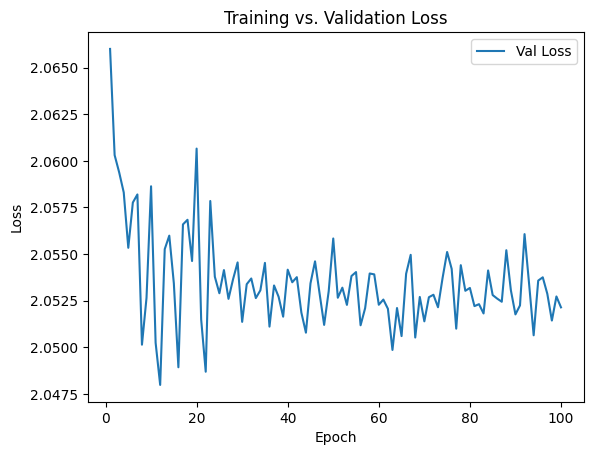

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_losses) + 1))

plt.figure()
# plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()


In [ ]:
model.load_state_dict(torch.load("best_asce_transformer.pt"))
model.eval()

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# (1) Move model to CPU for visualization
model_cpu = model.to('cpu')

# (2) Create a DataLoader over the entire dataset (no shuffling)
full_loader = DataLoader(dataset, batch_size=64, shuffle=False)

# (3) Extract the d_model‐dim feature for each window by forwarding through everything
all_features = []
all_labels   = []
with torch.no_grad():
    for xb, yb in full_loader:
        xb = xb.cpu()
        # Manually run up through the transformer, stopping at the pooled output:
        x_proj   = model_cpu.input_proj(xb)                             # (B, L, d_model)
        x_pos    = x_proj + model_cpu.pos_emb[:, :x_proj.size(1), :]     # add pos emb
        x_trans  = model_cpu.transformer(x_pos)                          # (B, L, d_model)
        features = x_trans.mean(dim=1)                                   # (B, d_model)
        all_features.append(features.numpy())
        all_labels.append(yb.numpy())

# (4) Stack everything into arrays
features_array = np.vstack(all_features)   # shape: (n_windows, d_model)
labels_array   = np.concatenate(all_labels)

# (5) PCA → 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_array)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    pca_result[:,0], pca_result[:,1],
    c=labels_array, cmap='coolwarm', alpha=0.7
)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Transformer Features')
plt.legend(*scatter.legend_elements(), title="State")
plt.show()

# (6) t-SNE → 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, init='pca', random_state=42)
tsne_result = tsne.fit_transform(features_array)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    tsne_result[:,0], tsne_result[:,1],
    c=labels_array+1, cmap='coolwarm', alpha=0.7
)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE of Transformer Features')
plt.legend(*scatter.legend_elements(), title="State")
plt.show()
# ────────────────────────────────────────────────────────────


NameError: name 'model' is not defined

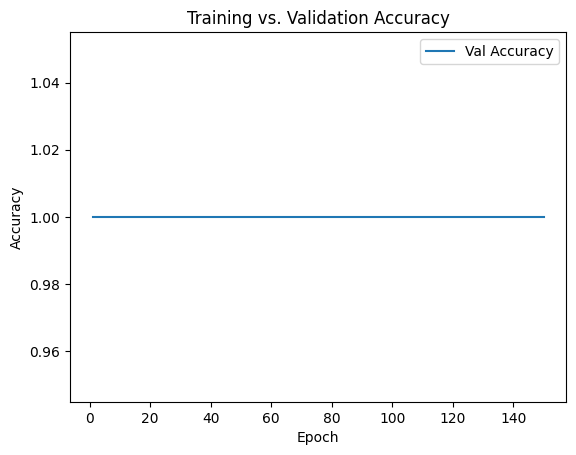

In [ ]:
plt.figure()
# plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs,   label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.show()


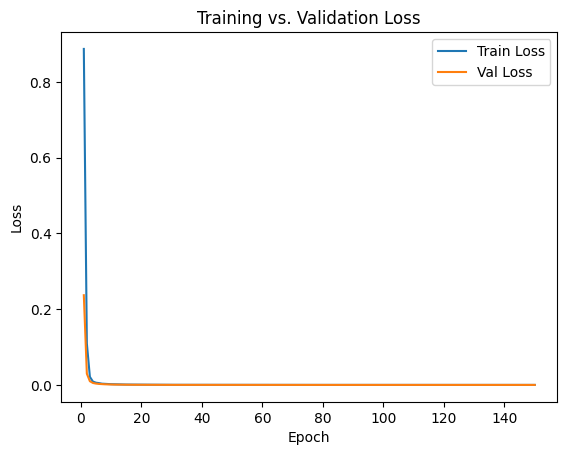

Confusion Matrix:
              Pred State1  Pred State2  Pred State3  Pred State4  Pred State5  \
True State1            6            0            0            0            0   
True State2            0           13            0            0            0   
True State3            0            0           11            0            0   
True State4            0            0            0           11            0   
True State5            0            0            0            0           12   
True State6            0            0            0            0            0   
True State7            0            0            0            0            0   
True State8            0            0            0            0            0   
True State9            0            0            0            0            0   

             Pred State6  Pred State7  Pred State8  Pred State9  
True State1            0            0            0            0  
True State2            0            0           

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch

# 1) Plot training & validation loss
epochs = list(range(1, len(train_losses) + 1))
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

# 2) Compute confusion matrix on the test set
# Move model back to the correct device (assuming 'device' is defined as cuda)
model.to(device)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(yb.cpu().numpy())

# Build & display as a DataFrame
cm = confusion_matrix(all_targets, all_preds)
df_cm = pd.DataFrame(
    cm,
    # index=['True State1','True State7'],
    # columns=['Pred State1','Pred State7']
    index=['True State1','True State2','True State3','True State4','True State5', 'True State6', 'True State7', 'True State8','True State9'],
    columns=['Pred State1','Pred State2','Pred State3','Pred State4', 'Pred State5', 'Pred State6', 'Pred State7', 'Pred State8', 'Pred State9']
)
print("Confusion Matrix:\n", df_cm)